# **Image Classification Model Training**

### Imports

In [1]:
import os
import json
import random
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
# from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore

2024-08-28 22:41:04.193576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 22:41:04.206909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 22:41:04.210778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 22:41:04.221571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 22:41:05.454614: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", (tf.config.list_physical_devices()))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724865066.620963   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865066.816545   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865066.818181   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
training_folder = '../data/images/training/'
validation_folder = '../data/images/validation/'

training_sensitive_dir = os.path.join(training_folder + 'sensitive/')
training_nonsensitive_dir = os.path.join(training_folder + 'nonsensitive/')
validation_sensitive_dir = os.path.join(validation_folder + 'sensitive/')
validation_nonsensitive_dir = os.path.join(validation_folder + 'nonsensitive/')

In [4]:
# Image Dataset size
print('Total training sensitive images:', len(os.listdir(training_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(training_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 300
Total training nonsensitive images: 300
Total validation sensitive images: 50
Total validation nonsensitive images: 50


## Sample Data

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [7]:
train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

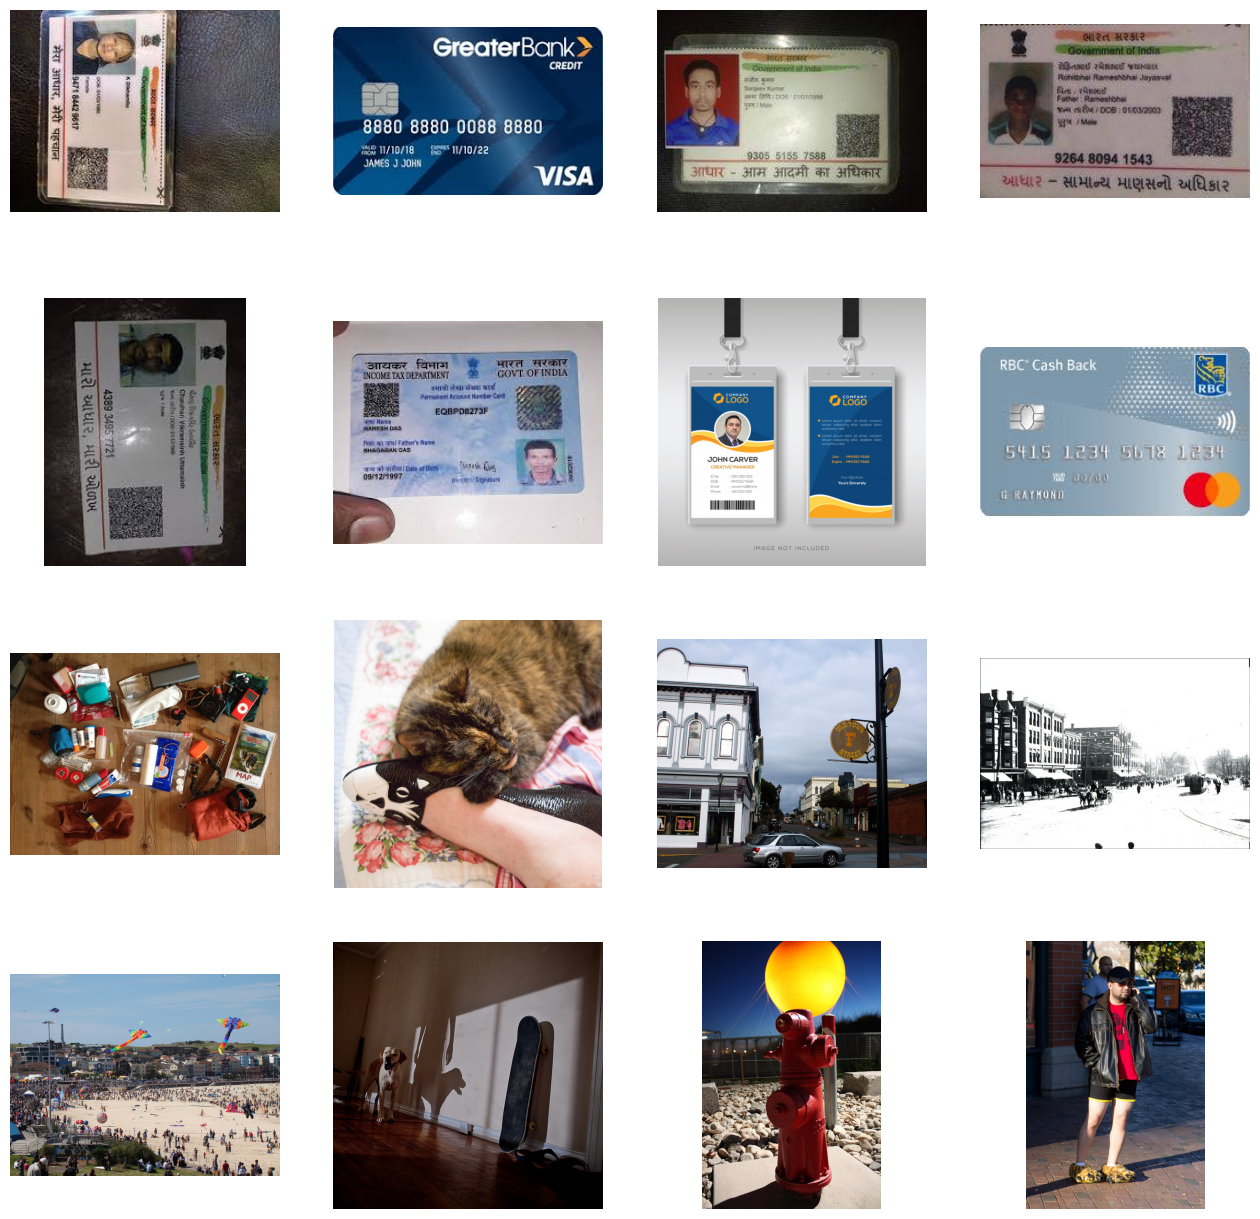

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)


plt.show()

## Model

In [9]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
from tensorflow.keras.optimizers import RMSprop #type:ignore
DESIRED_ACCURACY = 0.98


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > DESIRED_ACCURACY:
            print("Reached 98% accuracy so cancelling training!")
            self.model.stop_training = True


callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
    # 2D Convolution Layer - Filter, Kernel_size, activation fn
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(150, 150, 3)),
    # Max pooling operation for 2D data - Pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flattens the input. Does not affect the batch size.
    tf.keras.layers.Flatten(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(512, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

I0000 00:00:1724865067.974914   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865067.976534   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865067.977820   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865068.114330   79996 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocessing, Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [11]:
# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

In [12]:
# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
    training_folder,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(150, 150),
    batch_size=5,
    class_mode='binary',
    shuffle=True
)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Model Training

In [13]:
num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=num_epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=8,
    callbacks=[callbacks])

Epoch 1/500


I0000 00:00:1724865071.390507   80126 service.cc:146] XLA service 0x7f544c00eb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724865071.390577   80126 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-08-28 22:41:11.422786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 22:41:11.644487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:18 9s/step - accuracy: 0.6333 - loss: 0.6919

I0000 00:00:1724865077.919842   80126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.5439 - loss: 0.8356 - val_accuracy: 0.8000 - val_loss: 0.5805
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7247 - loss: 0.6022 - val_accuracy: 0.6250 - val_loss: 0.5818
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6500 - val_loss: 0.4987
Epoch 4/500


2024-08-28 22:41:20.475239: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-28 22:41:20.475281: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:41:20.475305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:20.475318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:20.528501: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:41:20.528567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous re

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7029 - loss: 0.5888 - val_accuracy: 0.8000 - val_loss: 0.4101
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6643 - loss: 0.5750 - val_accuracy: 0.7750 - val_loss: 0.5230
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.4801
Epoch 7/500


2024-08-28 22:41:23.717439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:23.755373: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:41:23.755412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:23.755430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6920 - loss: 0.6146 - val_accuracy: 0.8500 - val_loss: 0.4142
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7010 - loss: 0.5389 - val_accuracy: 0.8500 - val_loss: 0.3519
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.3245
Epoch 10/500


2024-08-28 22:41:27.024993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:27.077553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:27.077590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.7404 - loss: 0.5551 - val_accuracy: 0.9250 - val_loss: 0.2760
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7563 - loss: 0.4987 - val_accuracy: 0.9250 - val_loss: 0.2655
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.2315
Epoch 13/500


2024-08-28 22:41:30.222331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:30.222381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:30.262433: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:41:30.262473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:30.262490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7560 - loss: 0.5293 - val_accuracy: 0.9000 - val_loss: 0.3284
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7871 - loss: 0.4475 - val_accuracy: 0.8750 - val_loss: 0.2001
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.3617
Epoch 16/500


2024-08-28 22:41:33.702371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:33.702399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:33.736775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:33.736820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8077 - loss: 0.4274 - val_accuracy: 0.8750 - val_loss: 0.3464
Epoch 17/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7624 - loss: 0.4599 - val_accuracy: 0.9000 - val_loss: 0.3066
Epoch 18/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1919
Epoch 19/500


2024-08-28 22:41:37.032062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:37.032108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:37.058546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:37.058591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8094 - loss: 0.4398 - val_accuracy: 0.8250 - val_loss: 0.3785
Epoch 20/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7785 - loss: 0.5056 - val_accuracy: 0.9250 - val_loss: 0.3217
Epoch 21/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.2787
Epoch 22/500


2024-08-28 22:41:40.410575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:40.410618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:40.445664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:40.445696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7776 - loss: 0.4800 - val_accuracy: 0.9750 - val_loss: 0.2048
Epoch 23/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8127 - loss: 0.4162 - val_accuracy: 0.9000 - val_loss: 0.2826
Epoch 24/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.2026
Epoch 25/500


2024-08-28 22:41:43.665161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:43.665202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:43.710563: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:41:43.710627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:43.710638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8223 - loss: 0.4190 - val_accuracy: 0.9250 - val_loss: 0.2364
Epoch 26/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8348 - loss: 0.3806 - val_accuracy: 0.9000 - val_loss: 0.2172
Epoch 27/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1830
Epoch 28/500


2024-08-28 22:41:47.043292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:47.043321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:47.072961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:47.072992: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8505 - loss: 0.3621 - val_accuracy: 0.8250 - val_loss: 0.3986
Epoch 29/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8086 - loss: 0.3921 - val_accuracy: 1.0000 - val_loss: 0.1091
Epoch 30/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1544
Epoch 31/500


2024-08-28 22:41:50.151312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:50.151340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:50.194582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:50.194613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8190 - loss: 0.3636 - val_accuracy: 0.8750 - val_loss: 0.2234
Epoch 32/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7944 - loss: 0.4540 - val_accuracy: 0.9500 - val_loss: 0.1849
Epoch 33/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1377
Epoch 34/500


2024-08-28 22:41:53.421809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:53.421851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.8732 - loss: 0.3295 - val_accuracy: 0.8750 - val_loss: 0.2481
Epoch 35/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8259 - loss: 0.3956 - val_accuracy: 0.9500 - val_loss: 0.1442
Epoch 36/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2472
Epoch 37/500


2024-08-28 22:41:56.909327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:56.909365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:41:56.956728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:41:56.956783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.8555 - loss: 0.3587 - val_accuracy: 0.9000 - val_loss: 0.1985
Epoch 38/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8351 - loss: 0.3516 - val_accuracy: 0.9250 - val_loss: 0.2144
Epoch 39/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0617
Epoch 40/500


2024-08-28 22:42:00.260928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:00.260957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:00.298122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:00.298152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8626 - loss: 0.3098 - val_accuracy: 0.9250 - val_loss: 0.1904
Epoch 41/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8573 - loss: 0.3378 - val_accuracy: 0.9000 - val_loss: 0.2175
Epoch 42/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2626
Epoch 43/500


2024-08-28 22:42:03.791982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:03.792013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:03.827542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:03.827573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.8577 - loss: 0.3447 - val_accuracy: 0.9000 - val_loss: 0.1488
Epoch 44/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8760 - loss: 0.3035 - val_accuracy: 0.9000 - val_loss: 0.1285
Epoch 45/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0950
Epoch 46/500


2024-08-28 22:42:07.255952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:07.255988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:07.318135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:07.318174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.8601 - loss: 0.2651 - val_accuracy: 0.9500 - val_loss: 0.1039
Epoch 47/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8671 - loss: 0.3078 - val_accuracy: 1.0000 - val_loss: 0.0664
Epoch 48/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1617
Epoch 49/500


2024-08-28 22:42:10.560297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:10.560343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:10.594863: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:42:10.594891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:10.594905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8331 - loss: 0.3470 - val_accuracy: 0.9250 - val_loss: 0.1861
Epoch 50/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8474 - loss: 0.2935 - val_accuracy: 0.8500 - val_loss: 0.2783
Epoch 51/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.5045
Epoch 52/500


2024-08-28 22:42:14.063837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:14.063872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:14.117371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:14.117432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8506 - loss: 0.3708 - val_accuracy: 0.8750 - val_loss: 0.1744
Epoch 53/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9329 - loss: 0.2178 - val_accuracy: 0.9000 - val_loss: 0.2670
Epoch 54/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.2781
Epoch 55/500


2024-08-28 22:42:17.366124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:17.366162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:17.421007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:17.421072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9106 - loss: 0.2213 - val_accuracy: 0.9500 - val_loss: 0.1251
Epoch 56/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8629 - loss: 0.3788 - val_accuracy: 1.0000 - val_loss: 0.0911
Epoch 57/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.2040
Epoch 58/500


2024-08-28 22:42:20.732727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:20.757493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:20.757535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9190 - loss: 0.1949 - val_accuracy: 0.9750 - val_loss: 0.0945
Epoch 59/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8654 - loss: 0.3085 - val_accuracy: 0.9250 - val_loss: 0.1606
Epoch 60/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0784
Epoch 61/500


2024-08-28 22:42:23.854512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:23.854540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:23.899147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:23.899189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9135 - loss: 0.2121 - val_accuracy: 0.9500 - val_loss: 0.1332
Epoch 62/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8733 - loss: 0.2593 - val_accuracy: 0.9750 - val_loss: 0.0593
Epoch 63/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1542
Epoch 64/500


2024-08-28 22:42:27.026824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:27.026875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:27.072591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:27.072628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.8858 - loss: 0.2651 - val_accuracy: 0.9750 - val_loss: 0.0591
Epoch 65/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9032 - loss: 0.2333 - val_accuracy: 0.9750 - val_loss: 0.0765
Epoch 66/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0461
Epoch 67/500


2024-08-28 22:42:30.342628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:30.342668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:30.386424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:30.386480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.8787 - loss: 0.2752 - val_accuracy: 0.9500 - val_loss: 0.1637
Epoch 68/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9443 - loss: 0.1873 - val_accuracy: 0.9250 - val_loss: 0.1918
Epoch 69/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.2639
Epoch 70/500


2024-08-28 22:42:33.751381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:33.751413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:33.792652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:33.792704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9405 - loss: 0.1668 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 71/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9171 - loss: 0.2280 - val_accuracy: 0.9500 - val_loss: 0.1683
Epoch 72/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1229
Epoch 73/500


2024-08-28 22:42:37.102101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:37.102139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:37.143431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:37.143476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.9443 - loss: 0.1739 - val_accuracy: 1.0000 - val_loss: 0.0312
Epoch 74/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8985 - loss: 0.2906 - val_accuracy: 0.9500 - val_loss: 0.0930
Epoch 75/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0742
Epoch 76/500


2024-08-28 22:42:40.571422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:40.571464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:40.606833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:40.606877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9017 - loss: 0.2252 - val_accuracy: 0.9000 - val_loss: 0.1715
Epoch 77/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9353 - loss: 0.2058 - val_accuracy: 0.9750 - val_loss: 0.0648
Epoch 78/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1742
Epoch 79/500


2024-08-28 22:42:43.778449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:43.778485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:43.809286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:43.809334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9427 - loss: 0.1541 - val_accuracy: 0.9750 - val_loss: 0.0435
Epoch 80/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9329 - loss: 0.2031 - val_accuracy: 0.9500 - val_loss: 0.1151
Epoch 81/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0443
Epoch 82/500


2024-08-28 22:42:47.139366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:47.139406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:47.174164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:47.174197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9353 - loss: 0.1897 - val_accuracy: 0.9250 - val_loss: 0.2965
Epoch 83/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9392 - loss: 0.1645 - val_accuracy: 0.8000 - val_loss: 0.4633
Epoch 84/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.5186
Epoch 85/500


2024-08-28 22:42:50.572669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:50.572708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:50.605839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:50.605871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.8824 - loss: 0.2758 - val_accuracy: 0.9750 - val_loss: 0.0607
Epoch 86/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9209 - loss: 0.2152 - val_accuracy: 0.9500 - val_loss: 0.1457
Epoch 87/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0527
Epoch 88/500


2024-08-28 22:42:53.809826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:53.809865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:53.864232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:53.864261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9441 - loss: 0.1345 - val_accuracy: 0.9250 - val_loss: 0.1505
Epoch 89/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9318 - loss: 0.2091 - val_accuracy: 0.9500 - val_loss: 0.1324
Epoch 90/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0484
Epoch 91/500


2024-08-28 22:42:57.155627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:42:57.155655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:42:57.184708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9205 - loss: 0.1720 - val_accuracy: 0.8750 - val_loss: 0.3170
Epoch 92/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9258 - loss: 0.1847 - val_accuracy: 0.9000 - val_loss: 0.2506
Epoch 93/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1362
Epoch 94/500


2024-08-28 22:43:00.418598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:00.472825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:00.472853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9613 - loss: 0.1278 - val_accuracy: 0.8750 - val_loss: 0.2452
Epoch 95/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9637 - loss: 0.1110 - val_accuracy: 0.9250 - val_loss: 0.1275
Epoch 96/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0641
Epoch 97/500


2024-08-28 22:43:03.640946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:03.668498: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 22:43:03.668598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:03.668619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8894 - loss: 0.2977 - val_accuracy: 0.9750 - val_loss: 0.1165
Epoch 98/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8944 - loss: 0.2439 - val_accuracy: 0.9000 - val_loss: 0.3279
Epoch 99/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.4075
Epoch 100/500


2024-08-28 22:43:06.769844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:06.805562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:06.805606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9144 - loss: 0.2260 - val_accuracy: 1.0000 - val_loss: 0.0555
Epoch 101/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9049 - loss: 0.2170 - val_accuracy: 0.9750 - val_loss: 0.0886
Epoch 102/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0600
Epoch 103/500


2024-08-28 22:43:10.029710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:10.029747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:10.064284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:10.064334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9249 - loss: 0.1738 - val_accuracy: 1.0000 - val_loss: 0.0592
Epoch 104/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9421 - loss: 0.1344 - val_accuracy: 1.0000 - val_loss: 0.0563
Epoch 105/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0735
Epoch 106/500


2024-08-28 22:43:13.301572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:13.301601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:13.332873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:13.332904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9154 - loss: 0.1632 - val_accuracy: 0.9750 - val_loss: 0.0709
Epoch 107/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9362 - loss: 0.1436 - val_accuracy: 0.9750 - val_loss: 0.0648
Epoch 108/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0954
Epoch 109/500


2024-08-28 22:43:16.493738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:16.493767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:16.526540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:16.526578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9421 - loss: 0.1280 - val_accuracy: 0.9250 - val_loss: 0.1927
Epoch 110/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9602 - loss: 0.1298 - val_accuracy: 0.9750 - val_loss: 0.0464
Epoch 111/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2423
Epoch 112/500


2024-08-28 22:43:19.827677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:19.827722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:19.873973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:19.874009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9763 - loss: 0.0904 - val_accuracy: 0.8750 - val_loss: 0.1904
Epoch 113/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9290 - loss: 0.1848 - val_accuracy: 0.9500 - val_loss: 0.0931
Epoch 114/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.2222
Epoch 115/500


2024-08-28 22:43:23.098701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:23.098740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:23.151117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:23.151149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9372 - loss: 0.1265 - val_accuracy: 0.9000 - val_loss: 0.1482
Epoch 116/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9388 - loss: 0.1495 - val_accuracy: 0.9250 - val_loss: 0.1537
Epoch 117/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1077
Epoch 118/500


2024-08-28 22:43:26.361349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:26.361387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:26.398399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:26.398426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9266 - loss: 0.1812 - val_accuracy: 0.8000 - val_loss: 0.4130
Epoch 119/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9580 - loss: 0.1357 - val_accuracy: 0.9250 - val_loss: 0.1150
Epoch 120/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1084
Epoch 121/500


2024-08-28 22:43:29.458054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:29.458084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:29.499014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:29.499060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9181 - loss: 0.2019 - val_accuracy: 0.9250 - val_loss: 0.2068
Epoch 122/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9569 - loss: 0.1177 - val_accuracy: 0.9750 - val_loss: 0.1216
Epoch 123/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0906
Epoch 124/500


2024-08-28 22:43:32.604194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:32.604229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:32.641562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:32.641590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9451 - loss: 0.1377 - val_accuracy: 0.9500 - val_loss: 0.1725
Epoch 125/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9525 - loss: 0.1283 - val_accuracy: 0.9500 - val_loss: 0.1700
Epoch 126/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0730
Epoch 127/500


2024-08-28 22:43:35.873838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:35.873870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:35.913452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:35.913498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9470 - loss: 0.1238 - val_accuracy: 0.9750 - val_loss: 0.1700
Epoch 128/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9293 - loss: 0.1732 - val_accuracy: 0.9000 - val_loss: 0.3046
Epoch 129/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.4835
Epoch 130/500


2024-08-28 22:43:39.011014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:39.011043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:39.049824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:39.049853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9208 - loss: 0.2006 - val_accuracy: 0.9750 - val_loss: 0.0786
Epoch 131/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9525 - loss: 0.1555 - val_accuracy: 0.9000 - val_loss: 0.3011
Epoch 132/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1185
Epoch 133/500


2024-08-28 22:43:42.350584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:42.350619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9063 - loss: 0.2286 - val_accuracy: 0.9500 - val_loss: 0.1380
Epoch 134/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9148 - loss: 0.1684 - val_accuracy: 0.8750 - val_loss: 0.1841
Epoch 135/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1603
Epoch 136/500


2024-08-28 22:43:45.601802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:45.601865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:45.660196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:45.660227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9131 - loss: 0.1867 - val_accuracy: 1.0000 - val_loss: 0.0410
Epoch 137/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9447 - loss: 0.1347 - val_accuracy: 0.9750 - val_loss: 0.0645
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0952
Epoch 139/500


2024-08-28 22:43:49.042997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:49.043042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:49.097395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9255 - loss: 0.1838 - val_accuracy: 1.0000 - val_loss: 0.0431
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9461 - loss: 0.1398 - val_accuracy: 0.9250 - val_loss: 0.1179
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.3664
Epoch 142/500


2024-08-28 22:43:52.322778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:52.322823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:52.381605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:52.381654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9521 - loss: 0.1316 - val_accuracy: 0.9750 - val_loss: 0.0503
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9647 - loss: 0.0914 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 145/500


2024-08-28 22:43:55.917217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605
2024-08-28 22:43:55.953140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 966078404247769491
2024-08-28 22:43:55.953167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16882120044843486605


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9730 - loss: 0.1107 - val_accuracy: 0.9500 - val_loss: 0.1784
Epoch 146/500
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9676 - loss: 0.1102Reached 98% accuracy so cancelling training!
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9699 - loss: 0.1060 - val_accuracy: 0.9750 - val_loss: 0.0710


## Visualising Accuracy and Loss Functions

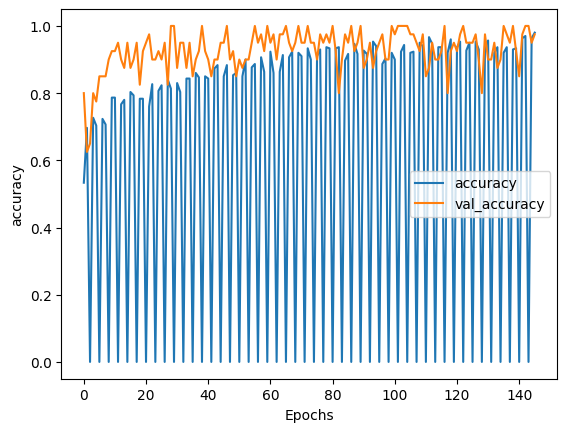

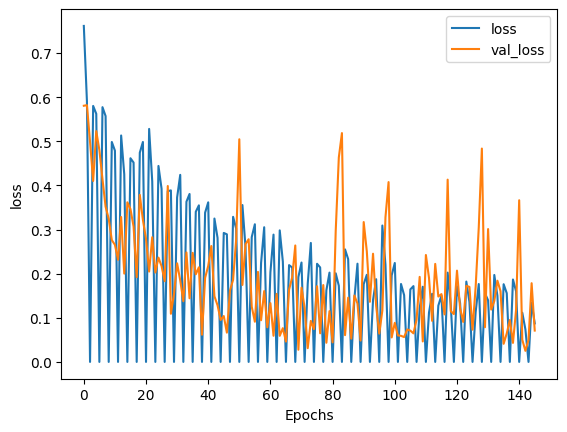

In [14]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Confusion Matrix
Accuracy for 25 Test Data =  52.0
Accuracy for 50 Test Data =  53.06122448979592
Accuracy for 75 Test Data =  53.333333333333336
Accuracy for 100 Test Data =  51.515151515151516


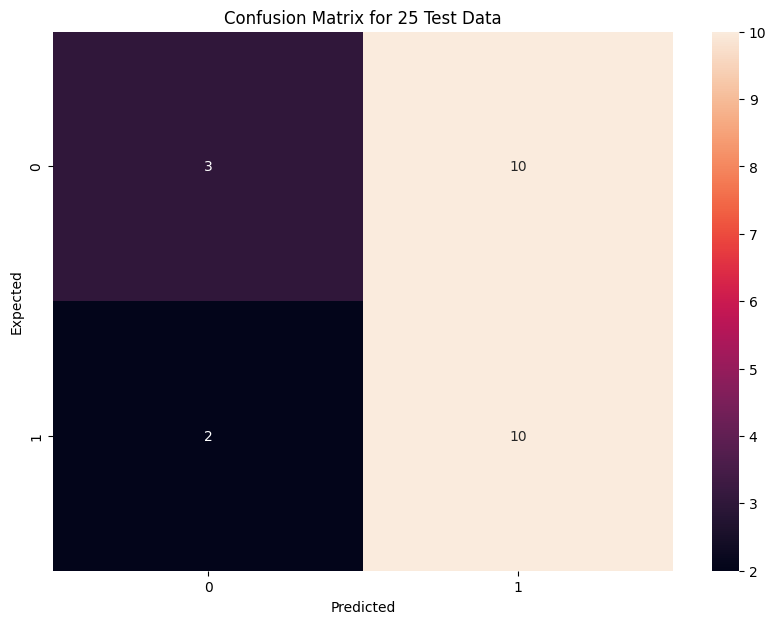

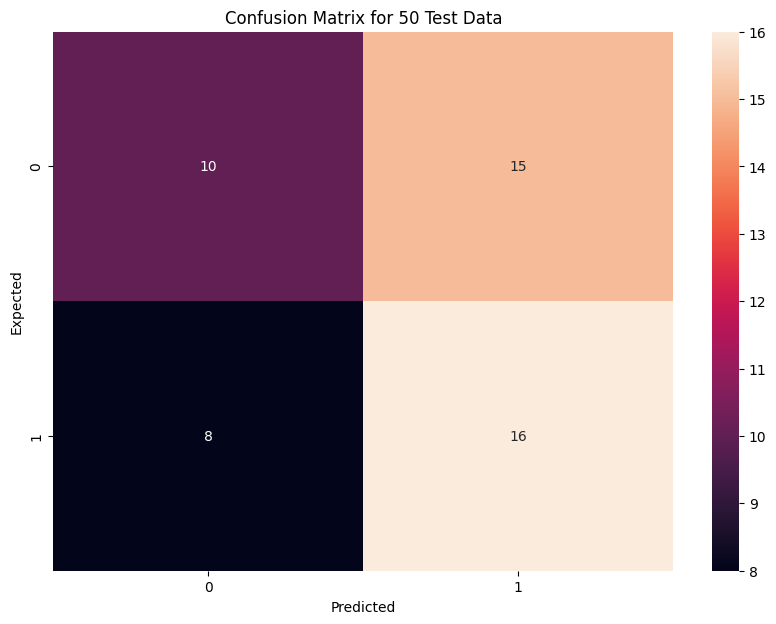

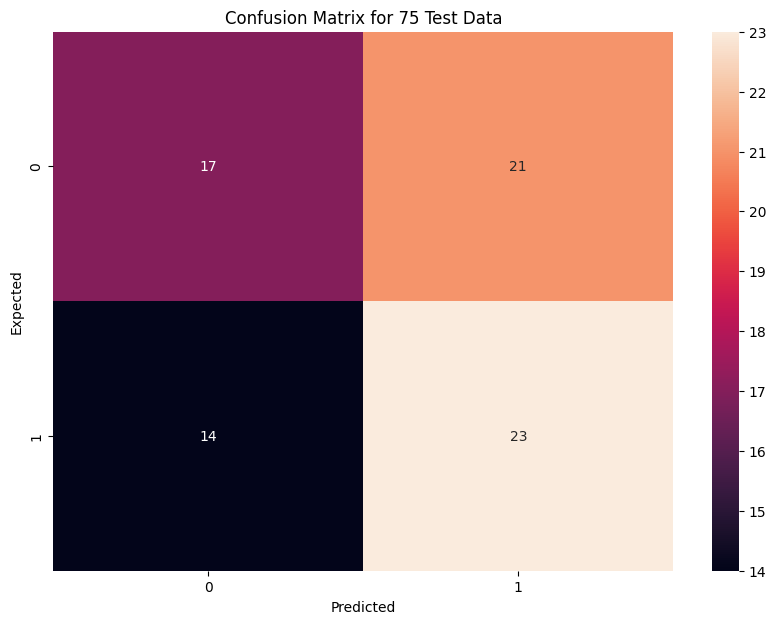

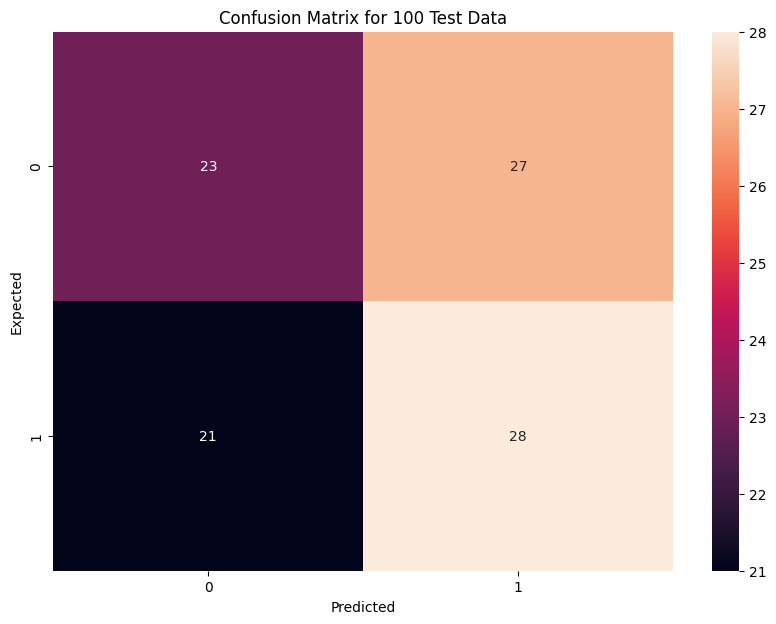

In [15]:
import seaborn
import numpy as np
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model locally

In [16]:
# Save and convert the model (Used for deploying in web application)
model.save('../models/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

Saved the model successfully
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
created virtual environment CPython3.11.9.final.0-64 in 389ms
  creator CPython3Posix(dest=/home/kali/Desktop/redact-sih/notebooks/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/kali/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==70.3.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
2024-08-28 22:44:04.753093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 22:44:04.769109: E external/local_xla/xla/stream_executor/cuda/cuda_

## Sample Data

In [17]:
from keras.preprocessing import image

sample_data = {'../data/images/validation/sensitive/aadhar (3).jpg',
               '../data/images/training/sensitive/aadharcard (3).jpg',
               '../data/images/training/nonsensitive/COCO_train2014_000000000064.jpg',
               '../data/images/training/nonsensitive/COCO_train2014_000000000009.jpg'}
result = dict()
count = 1
for path in sample_data:
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0] > 0.5:
        print(f"Image {count}" + " - Sensitive")
        result[f"Image {count}"] = "Sensitive"
    else:
        print(f"Image {count}" + " - Non-sensitive")
        result[f"Image {count}"] = "Non-sensitive"
    count += 1
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
[1.]
Image 1 - Sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.]
Image 2 - Non-sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1.]
Image 3 - Sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1.]
Image 4 - Sensitive
{'Image 1': 'Sensitive', 'Image 2': 'Non-sensitive', 'Image 3': 'Sensitive', 'Image 4': 'Sensitive'}


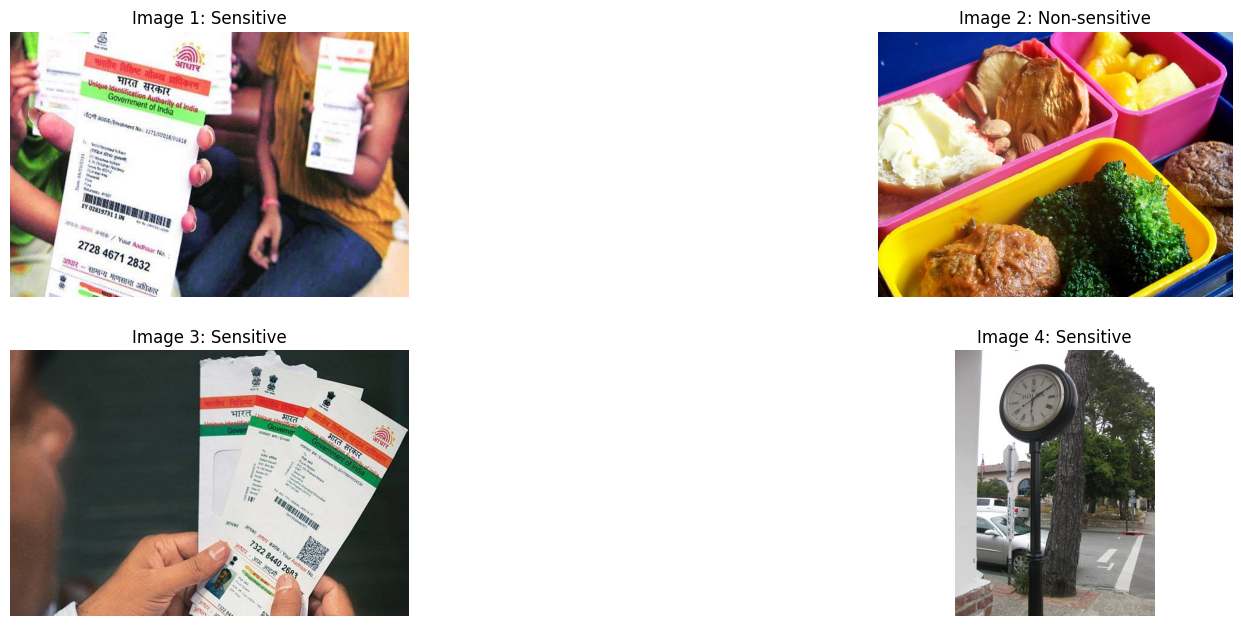

In [18]:
plt.figure(figsize=(20, 20))
count = 1
for i, fn in enumerate(sample_data):
    
    image = plt.imread(fn)
    plt.subplot(5, 2, i+1)
    plt.axis("off")
    plt.imshow(image)
    ans = f"Image {count}" + ": " + result[f"Image {count}"]
    plt.title(ans)
    count +=1